In [ ]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import random

In [ ]:
def extract_first_features(filters, size):
  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2D(filters, size, strides=1, padding='same', use_bias=False))    
  result.add(tf.keras.layers.BatchNormalization())
  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
x = tf.random.normal((1, 256, 1024, 3))
print(x.shape)

(1, 256, 1024, 3)


In [ ]:
output = extract_first_features(64, 3)(x)
print(output.shape)

(1, 256, 1024, 64)


In [ ]:
def downsample(filters, size):
  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2D(filters, size, 
                                    strides=2, 
                                    padding='same', 
                                    use_bias=False))  
  result.add(tf.keras.layers.ReLU())
  result.add(tf.keras.layers.BatchNormalization())

  return result

In [ ]:
x = tf.random.normal( (1, 256, 1024, 3) )
output = downsample(64, 4)(x)
print(output.shape)

(1, 128, 512, 64)


In [ ]:
def upsample(filters, size):
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.UpSampling2D(interpolation='bilinear'))
    result.add(tf.keras.layers.Conv2D(filters, 3, padding='same',
                                      kernel_initializer=initializer, 
                                      use_bias=False))    
    result.add(tf.keras.layers.ReLU())
    result.add(tf.keras.layers.BatchNormalization())

    return result

In [ ]:
def upsample(filters, size):
  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2DTranspose(filters, size, 
                                             strides=2,
                                             padding='same', 
                                             use_bias=False))  
  result.add(tf.keras.layers.ReLU())
  result.add(tf.keras.layers.BatchNormalization())

  return result

In [ ]:
x = tf.random.normal( (1, 256, 1024, 3) )
output = upsample(64, 4)(x)
print(output.shape)

(1, 512, 2048, 64)


In [ ]:
def UNet_process(x): # (1, 256, 1024, 3)
  # encoding
  down_stack = [
    downsample(64, 4),  # (bs, 128, 512, 64)
    downsample(256, 4), # (bs, 64, 256, 256)
    downsample(512, 4), # (bs, 32, 128, 512)
    downsample(512, 4), # (bs, 16, 64, 512)
    downsample(512, 4), # (bs, 8, 32, 512)
  ]

  for down in down_stack:
    x = down(x)

  # decoding
  up_stack = [
    upsample(512, 4), # (bs, 16, 64, 512)
    upsample(512, 4), # (bs, 32, 128, 512)
    upsample(256, 4), # (bs, 64, 256, 256)
    upsample(64, 4),  # (bs, 128, 512, 64)
  ]

  for up in up_stack:
    x = up(x)  

  # last layer  
  OUTPUT_CHANNELS = 3  
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 
                                         4, strides=2,
                                        padding='same', 
                                         activation='tanh')
  x = last(x)
  
  return x   

In [ ]:
x = tf.random.normal( (1, 256, 1024, 3) )
output = UNet_process(x)
print(output.shape)

(1, 128, 512, 64)


In [ ]:
def Generator(): 
  # inputs
  inputs = tf.keras.layers.Input(shape=[256, 1024, 3])    
  x = inputs
      
  # UNet_process
  output = UNet_process(x)

  return tf.keras.Model(inputs=[inputs], outputs=[output])

In [ ]:
def Generator(): 
  # inputs
  inputs = tf.keras.layers.Input(shape=[256, 1024, 3])    
  x = inputs

  # extract_first_features
  fextract = extract_first_features(64, 3)
  x = fextract(x) # (1,256,1024,64)
      
  # UNet_process
  output = UNet_process(x)

  return tf.keras.Model(inputs=[inputs], outputs=[output])

In [ ]:
generator = Generator()
generator.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256, 1024, 3)]    0         
_________________________________________________________________
sequential_51 (Sequential)   (None, 256, 1024, 64)     1984      
_________________________________________________________________
sequential_52 (Sequential)   (None, 128, 512, 64)      65792     
_________________________________________________________________
sequential_53 (Sequential)   (None, 64, 256, 256)      263168    
_________________________________________________________________
sequential_54 (Sequential)   (None, 32, 128, 512)      2099200   
_________________________________________________________________
sequential_55 (Sequential)   (None, 16, 64, 512)       4196352   
_________________________________________________________________
sequential_56 (Sequential)   (None, 8, 32, 512)        4196

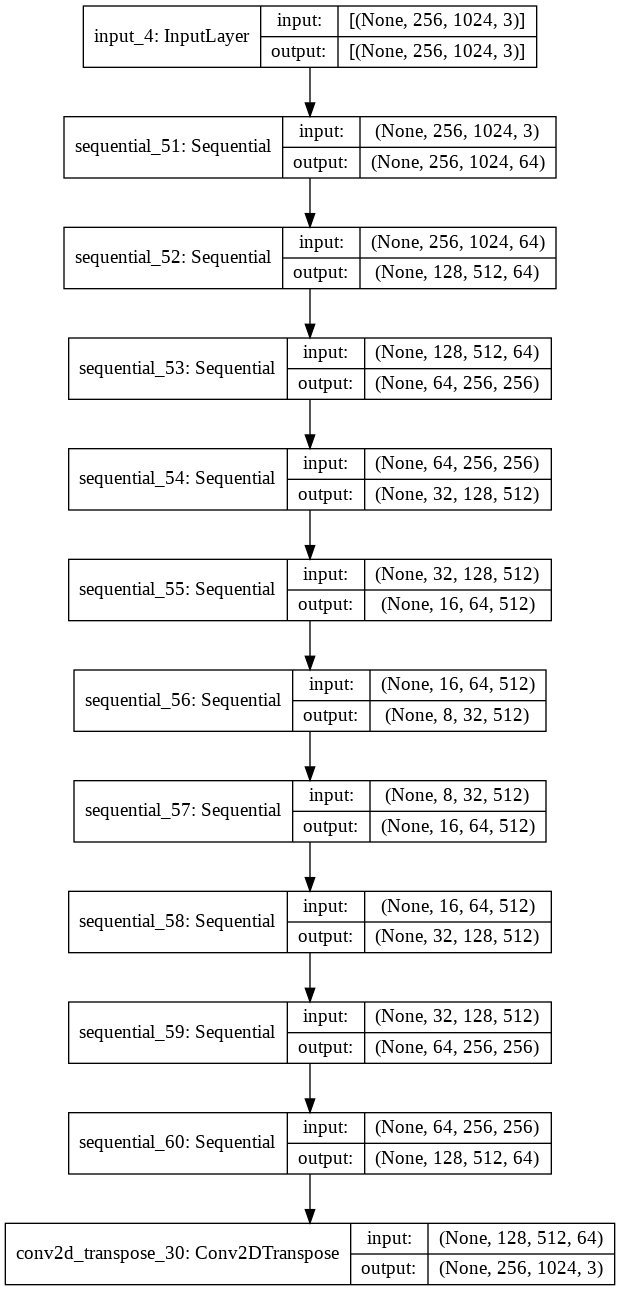

In [ ]:
tf.keras.utils.plot_model(generator, show_shapes=True)

In [ ]:
def UNet_process(x): # (1, 256, 1024, 3)
  # encoding
  down_stack = [
    downsample(64, 4),  # (bs, 128, 512, 64)
    downsample(256, 4), # (bs, 64, 256, 256)
    downsample(512, 4), # (bs, 32, 128, 512)
    downsample(512, 4), # (bs, 16, 64, 512)
    downsample(512, 4), # (bs, 8, 32, 512)
  ]

  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])


  # decoding
  up_stack = [
    upsample(512, 4), # (bs, 16, 64, 512)
    upsample(512, 4), # (bs, 32, 128, 512)
    upsample(256, 4), # (bs, 64, 256, 256)
    upsample(64, 4),  # (bs, 128, 512, 64)
  ]

  concat = tf.keras.layers.Concatenate()
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip])

  
  # last layer
  OUTPUT_CHANNELS = 3  
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 
                                         4, strides=2,
                                         padding='same', 
                                         activation='tanh')
  x = last(x)
    
  return x

In [ ]:
def Generator(): 
  # inputs
  inputs = tf.keras.layers.Input(shape=[256, 1024, 3])    
  x = inputs

  # extract_first_features
  fextract = extract_first_features(64, 3)  # (1, 256, 1024, 64)
  x = fextract(x) # (1,256,1024,64)
      
  # UNet_process
  output = UNet_process(x)

  return tf.keras.Model(inputs=[inputs], outputs=[output])

In [ ]:
generator = Generator()
generator.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 1024, 3 0                                            
__________________________________________________________________________________________________
sequential_41 (Sequential)      (None, 256, 1024, 64 1984        input_3[0][0]                    
__________________________________________________________________________________________________
sequential_42 (Sequential)      (None, 128, 512, 64) 65792       sequential_41[0][0]              
__________________________________________________________________________________________________
sequential_43 (Sequential)      (None, 64, 256, 256) 263168      sequential_42[0][0]              
____________________________________________________________________________________________

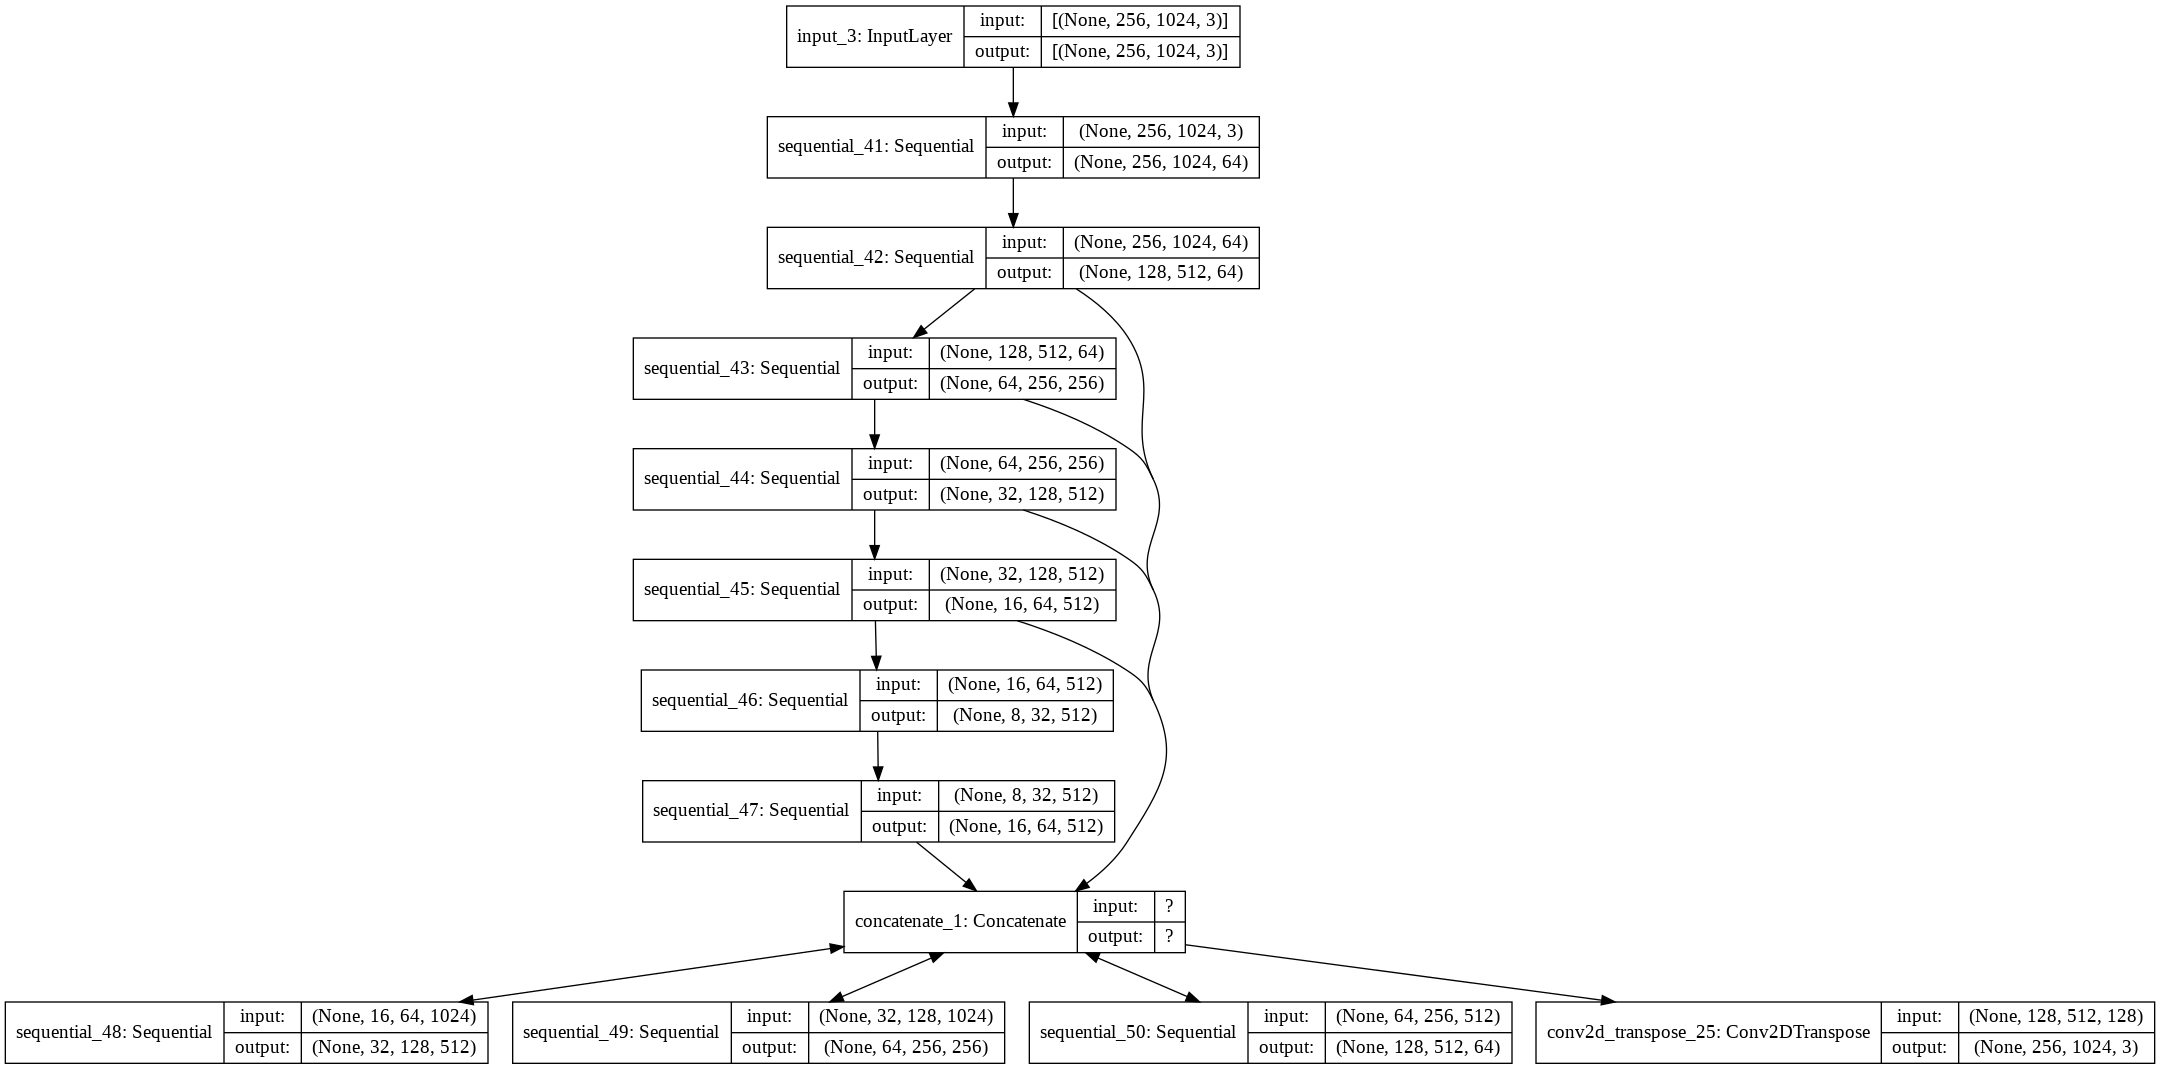

In [ ]:
tf.keras.utils.plot_model(generator, show_shapes=True)